In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 

from sklearn.metrics import r2_score
import math

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        y = 1/math.sqrt(hidden_size)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model

def change_padder(seqs, cue_dict, xval):
    """ changes value of X from zero to a new value
        and recalculates sequence output"""
    cue_dict['X'] = xval
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, cue_dict, bidmas = False))

    return inps, cue_dict

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict, bidmas = False))

    return inps, cue_dict

def predcorr(mods, tests):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
        all_dfs1 = pd.concat(dfs1) 
        preds, labs = all_dfs1['pred'], all_dfs1['label']
        xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_score(all_dfs1['pred'],all_dfs1['label']), 2)) )
    
    return all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [26]:
def generate_other(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            combi_inputcue = list(itertools.combinations(input_ids, r=2))
            cue = random.choice(combi_inputcue)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

def test_other(operators, test, syms, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        input_ids = [test] + [random.choice(syms)]
        random.shuffle(input_ids)
        combi_inputcue = list(itertools.combinations(input_ids, r=2))
        cue = random.choice(combi_inputcue)
        op = random.choice(combi_operators)
        trial = [random.choice(syms),*zip(tuple(op), cue)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)

    return seq

def generate_self(operators, inputs, rep = 1):
    seq = []
    for _ in range(rep):
        for inp in inputs:
            trial = generate_sequences(operators, inp, len_seq = 2, cue_dict = cue_dict, init_values = inp)
            seq += trial
    return seq

def generate_dummy(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            inp = random.choice(input_ids)
            cue = (inp, inp)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

def generate_other_1step(operators, inputs, init_values):
    # remove init form inputs
    
    seq = []
    for init in init_values:
        input_ids = [val for val in inputs if val != init]
        cue = random.sample(input_ids, 2)
        op = random.choice(operators)
        trial = [init,(op, cue[0])]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
        op = random.choice(operators)
        trial = [cue[1],(op, init)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)

    return seq

def generate_min_other(operators, inputs, init_values):

    seq = []
    for inp in inputs:
        inits = [val for val in init_values if val != inp]
        init = random.choice(inits)
        op = random.choice(operators)
        trial = [init,(op, inp)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
        
    return seq


def generate_Xother(operators, inputs):
    # remove init form inputs
    
    seq = []
    for inp in inputs:
        op = random.choice(operators)
        trial = ['X',(op, inp)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
        
    return seq

def generate_self_1step(operators, inputs, init_values):  
    seq = []
    for init in init_values:
        op = random.choice(operators)
        trial = [init,(op, init)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
    
    return seq


# Parameters and Setup

In [4]:
def run_exp1(trainseqs_old, testseqs_old):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs, cd = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs, cd = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

# Experiments

With P
1. All permutations of 2 step + p
2. All permutations of 1 step + p
3. Only "Other" permutations of 1 step (B+C),(C+D) ... + p
4. Only "Self" permutations of 1 step (B+B),(D+D) ... + p
5. Min set of Xother (X+C),(X+B) .. + p

Without P


In [5]:
# params

# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.001

## running params
epochs = 1000
num_sims = 80
num_inputs = 5

In [6]:
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)

{'X': 0, 'A': 9, 'B': 10, 'C': 6, 'D': 16, 'E': 8}


# 1. All permuatations of 2 step

time:  48.65793148676554


,label,pred,acc
trial,,,
"['D', '+', 'A', '+', 'D']",30.1375,30.139159,0.9875
"['B', '+', 'A', '+', 'C']",27.9875,27.987696,0.9750
"['B', '+', 'A', '+', 'E']",27.7875,27.787236,0.9750
"['D', '+', 'C', '+', 'A']",29.3000,29.330424,0.8875
"['E', '+', 'D', '+', 'A']",29.1000,29.129069,0.8750
"['C', '+', 'E', '+', 'A']",28.2625,28.289961,0.8625
"['D', '+', 'E', '+', 'A']",29.1000,29.134947,0.8500


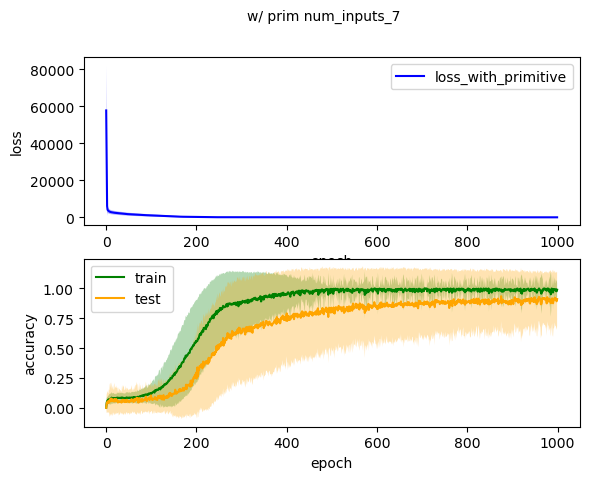

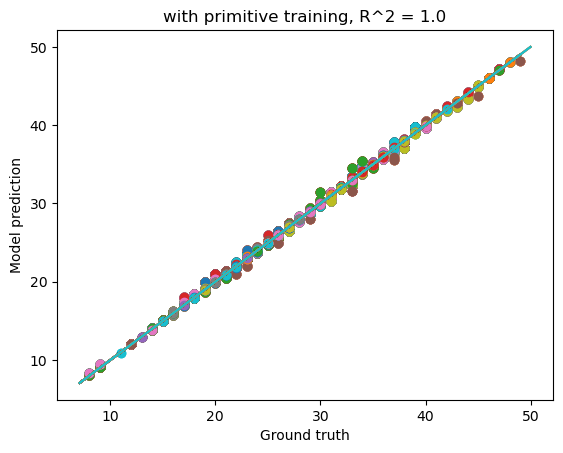

In [7]:
ops = ['+']
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + generate_sequences(['+'], all_syms[1:], len_seq = 2, cue_dict = cue_dict, init_values = all_syms[1:])
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)
testseqs = [val for val in testseqs if val not in trainseqs]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 2 - all permutations of 1 step

time:  49.02145229578018


,label,pred,acc
trial,,,
"['B', '+', 'A', '+', 'B']",26.1875,26.199919,0.9375
"['B', '+', 'A', '+', 'C']",27.1375,27.146325,0.9375
"['C', '+', 'A', '+', 'C']",28.0875,28.099139,0.9375
"['D', '+', 'A', '+', 'B']",27.0250,27.044635,0.9375
"['E', '+', 'A', '+', 'C']",28.3125,28.321686,0.9375
"['B', '+', 'A', '+', 'D']",27.0250,27.037485,0.9250
"['B', '+', 'B', '+', 'A']",26.1875,26.212494,0.9250
"['D', '+', 'B', '+', 'A']",27.0250,27.056552,0.9250
"['C', '+', 'C', '+', 'A']",28.0875,28.110415,0.9000


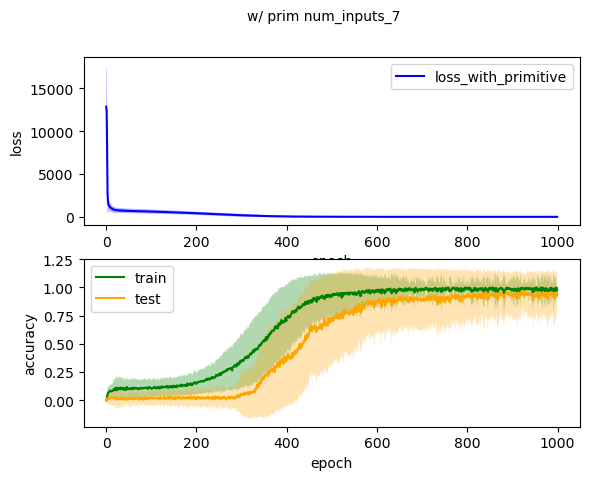

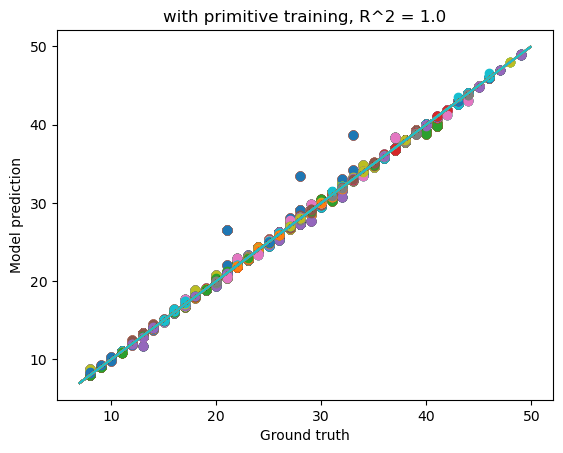

In [8]:
ops = ['+']
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_sequences(['+'], all_syms[1:], len_seq = 1, cue_dict = cue_dict, init_values = all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res2  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res2])
acc_train = np.array([r['acc'][:,0] for r in res2]).T
acc_test = np.array([r['acc'][:,1] for r in res2]).T
mods = [r['mod'] for r in res2]
tests = [r['test'] for r in res2]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 3 - Min set of self

time:  22.694866633415224


,label,pred,acc
trial,,,
"['B', '+', 'A', '+', 'D']",27.4375,27.524841,0.8125
"['D', '+', 'A', '+', 'D']",27.9250,28.017274,0.8125
"['E', '+', 'A', '+', 'B']",27.8250,27.925087,0.8000
"['B', '+', 'A', '+', 'E']",27.8250,27.912135,0.7625
"['C', '+', 'D', '+', 'A']",28.0375,28.052281,0.7250
"['D', '+', 'E', '+', 'A']",28.3125,28.349551,0.7250
"['B', '+', 'D', '+', 'A']",27.4375,27.472777,0.7125
"['B', '+', 'B', '+', 'A']",26.9500,27.032714,0.6875


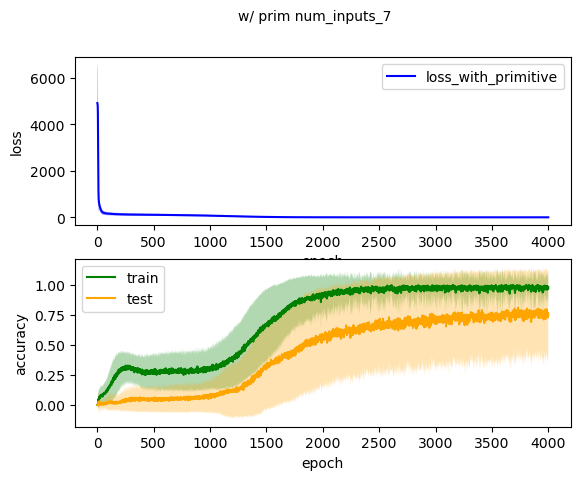

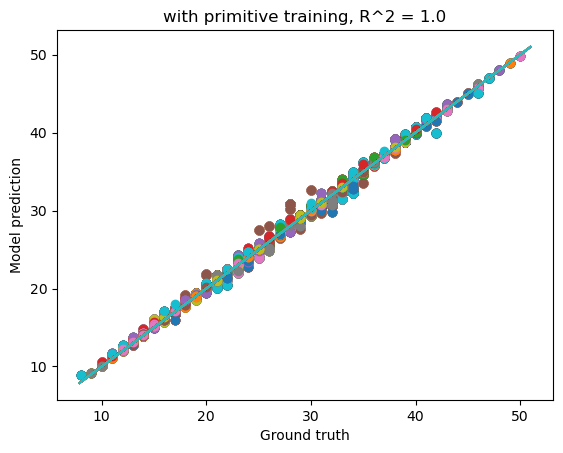

In [55]:
epochs = 4000
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_self_1step(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res3  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res3])
acc_train = np.array([r['acc'][:,0] for r in res3]).T
acc_test = np.array([r['acc'][:,1] for r in res3]).T
mods = [r['mod'] for r in res3]
tests = [r['test'] for r in res3]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 4 -  Double set of other

time:  8.95976812839508


,label,pred,acc
trial,,,
"['C', '+', 'A', '+', 'D']",30.0125,30.096527,0.9000
"['B', '+', 'A', '+', 'D']",28.4625,28.556562,0.8875
"['D', '+', 'A', '+', 'C']",30.0125,30.105587,0.8875
"['C', '+', 'A', '+', 'E']",28.9625,29.036657,0.8750
"['D', '+', 'B', '+', 'A']",28.4625,28.470538,0.8750
"['B', '+', 'A', '+', 'C']",28.7750,28.875479,0.8625
"['D', '+', 'A', '+', 'E']",28.6500,28.726789,0.8625
"['E', '+', 'D', '+', 'A']",28.6500,28.680490,0.8625
"['B', '+', 'E', '+', 'A']",27.4125,27.441873,0.8250


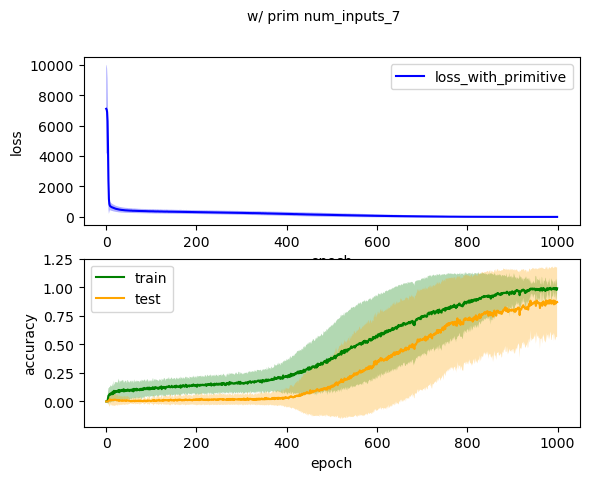

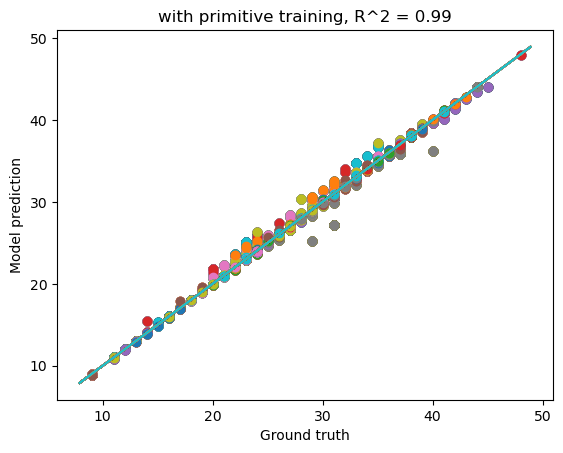

In [29]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res4  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res4])
acc_train = np.array([r['acc'][:,0] for r in res4]).T
acc_test = np.array([r['acc'][:,1] for r in res4]).T
mods = [r['mod'] for r in res4]
tests = [r['test'] for r in res4]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 5 -  Min set of other

time:  40.40326324701309


,label,pred,acc
trial,,,
"['B', '+', 'A', '+', 'C']",27.4750,26.709736,0.5125
"['D', '+', 'B', '+', 'A']",28.4875,28.053862,0.3625
"['E', '+', 'A', '+', 'C']",27.3250,26.688375,0.3625
"['B', '+', 'A', '+', 'E']",28.0125,26.928712,0.3375
"['C', '+', 'A', '+', 'E']",27.3250,26.226229,0.3375
"['D', '+', 'D', '+', 'A']",28.8125,28.223227,0.3250
"['D', '+', 'A', '+', 'D']",28.8125,27.859863,0.3125
"['E', '+', 'A', '+', 'E']",27.8625,26.907350,0.2875
"['C', '+', 'C', '+', 'A']",26.7875,26.163739,0.2750


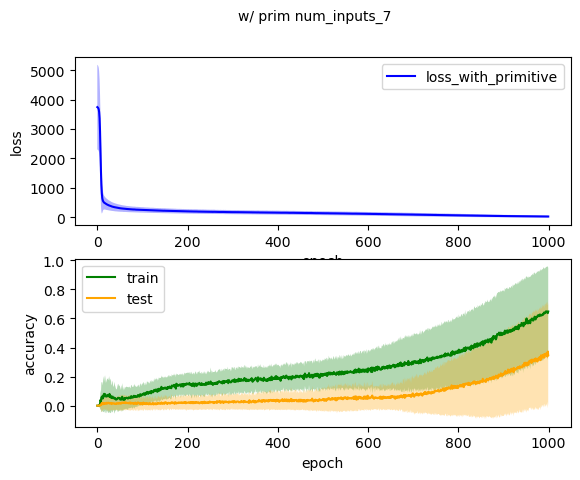

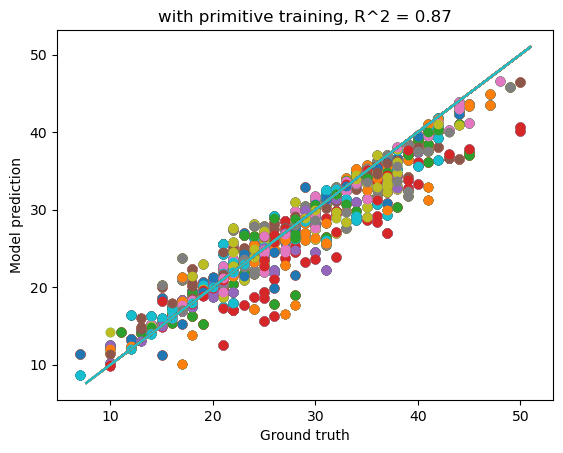

In [30]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res5  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res5])
acc_train = np.array([r['acc'][:,0] for r in res5]).T
acc_test = np.array([r['acc'][:,1] for r in res5]).T
mods = [r['mod'] for r in res5]
tests = [r['test'] for r in res5]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [32]:
epochs = 4000

time:  36.586433068911234


,label,pred,acc
trial,,,
"['B', '+', 'A', '+', 'D']",28.1500,28.168747,0.9500
"['E', '+', 'A', '+', 'B']",28.1750,28.192387,0.9500
"['D', '+', 'A', '+', 'C']",28.9375,28.951779,0.9375
"['B', '+', 'B', '+', 'A']",27.8000,27.733167,0.9125
"['C', '+', 'B', '+', 'A']",28.5875,28.518476,0.9000
"['D', '+', 'D', '+', 'A']",28.5000,28.419517,0.9000
"['E', '+', 'D', '+', 'A']",28.5250,28.446773,0.9000
"['C', '+', 'D', '+', 'A']",28.9375,28.861718,0.8875
"['E', '+', 'E', '+', 'A']",28.5500,28.458879,0.8750


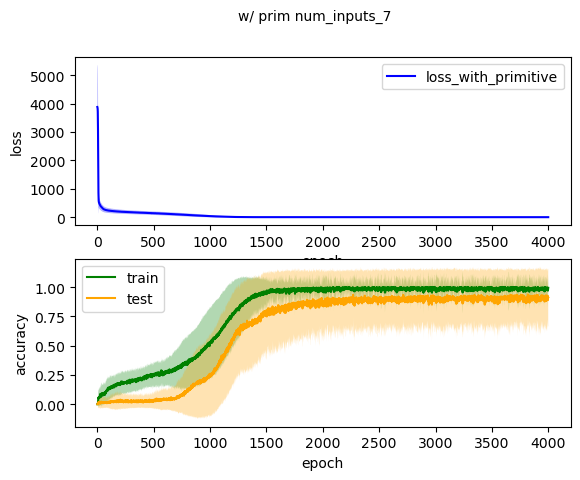

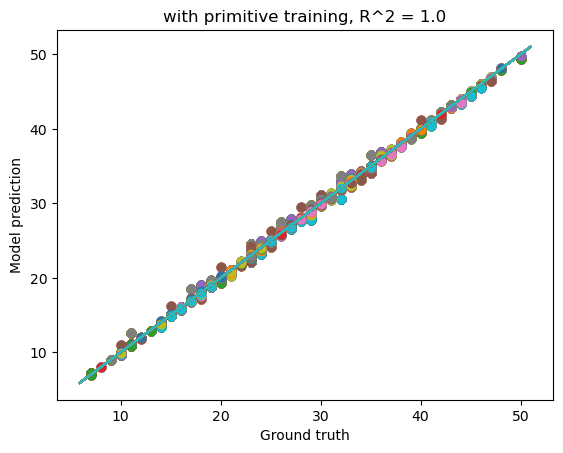

In [42]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res5  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res5])
acc_train = np.array([r['acc'][:,0] for r in res5]).T
acc_test = np.array([r['acc'][:,1] for r in res5]).T
mods = [r['mod'] for r in res5]
tests = [r['test'] for r in res5]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  36.089110998312634


,label,pred,acc
trial,,,
"['D', '+', 'A', '+', 'B']",27.3500,27.675243,0.7875
"['B', '+', 'A', '+', 'C']",25.8125,26.020958,0.7750
"['B', '+', 'A', '+', 'D']",27.3500,27.708709,0.7750
"['D', '+', 'A', '+', 'C']",27.0875,27.367016,0.7750
"['B', '+', 'A', '+', 'E']",26.6750,27.082360,0.7250
"['B', '+', 'C', '+', 'A']",25.8125,26.269561,0.6250
"['C', '+', 'C', '+', 'A']",25.5500,26.070158,0.6125
"['B', '+', 'E', '+', 'A']",26.6750,27.308514,0.5625
"['C', '+', 'E', '+', 'A']",26.4125,27.093367,0.5625


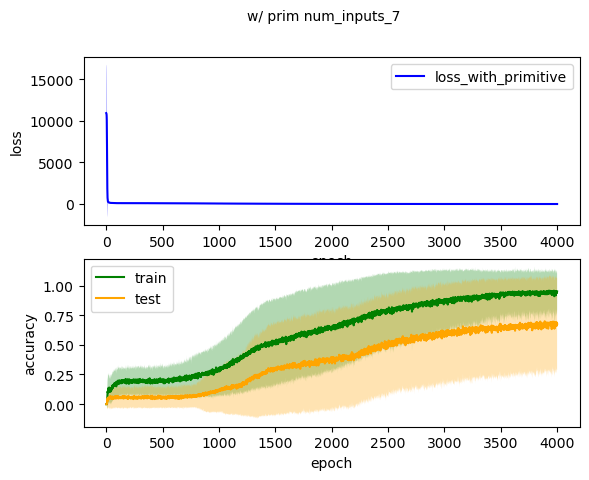

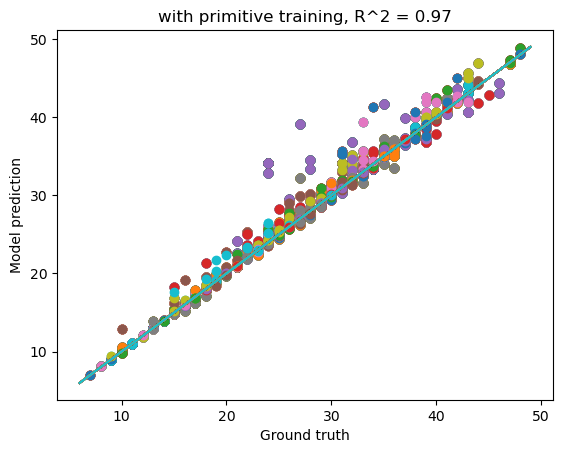

In [45]:
p = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'B'))
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:], all_syms[1:]), padder = ('+', 'B'))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res7  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res7])
acc_train = np.array([r['acc'][:,0] for r in res7]).T
acc_test = np.array([r['acc'][:,1] for r in res7]).T
mods = [r['mod'] for r in res7]
tests = [r['test'] for r in res7]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  34.96122099955877


,label,pred,acc
trial,,,
"['C', '+', 'A', '+', 'E']",28.1750,28.151159,0.9625
"['B', '+', 'A', '+', 'C']",28.5000,28.468778,0.9500
"['D', '+', 'A', '+', 'B']",29.3125,29.301049,0.9375
"['D', '+', 'A', '+', 'E']",28.9875,28.984523,0.9250
"['B', '+', 'A', '+', 'E']",28.8000,28.781348,0.9125
"['B', '+', 'C', '+', 'A']",28.5000,28.417329,0.9000
"['B', '+', 'D', '+', 'A']",29.3125,29.242009,0.9000
"['D', '+', 'C', '+', 'A']",28.6875,28.620504,0.8875
"['E', '+', 'C', '+', 'A']",28.1750,28.106795,0.8875


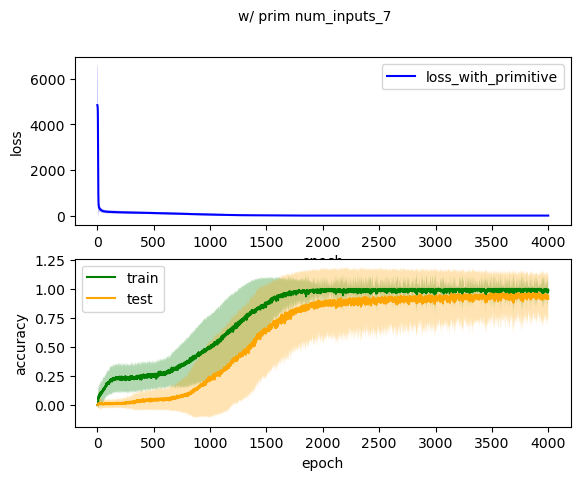

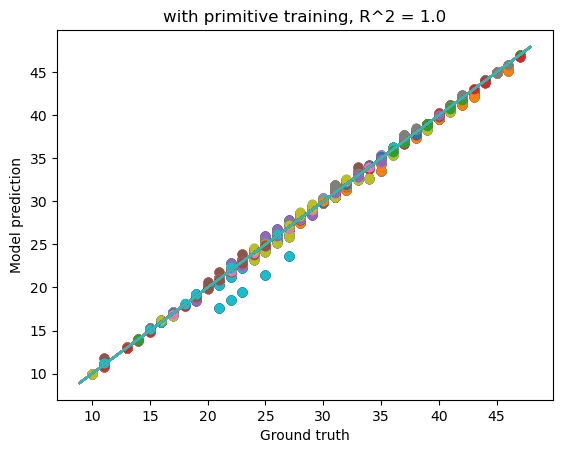

In [46]:
# try with X = 2

cue_dict['X'] = 2
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res5  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res5])
acc_train = np.array([r['acc'][:,0] for r in res5]).T
acc_test = np.array([r['acc'][:,1] for r in res5]).T
mods = [r['mod'] for r in res5]
tests = [r['test'] for r in res5]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 6 - Min set of Xother

time:  5.831418867905935


,label,pred,acc
trial,,,
"['B', '+', 'E', '+', 'A']",27.5625,11.474965,0.0
"['C', '+', 'B', '+', 'A']",27.6125,11.697050,0.0
"['C', '+', 'E', '+', 'A']",27.2875,11.422873,0.0
"['D', '+', 'D', '+', 'A']",28.9625,13.697098,0.0
"['E', '+', 'A', '+', 'B']",27.5625,11.214925,0.0
"['E', '+', 'A', '+', 'E']",27.2375,11.217595,0.0
"['E', '+', 'C', '+', 'A']",27.2875,11.168586,0.0
"['E', '+', 'E', '+', 'A']",27.2375,11.683907,0.0


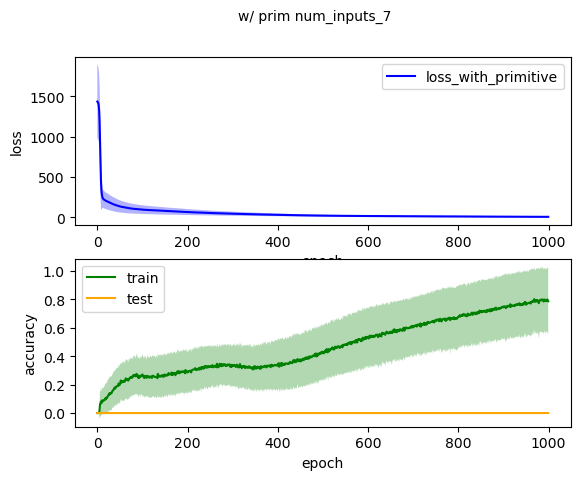

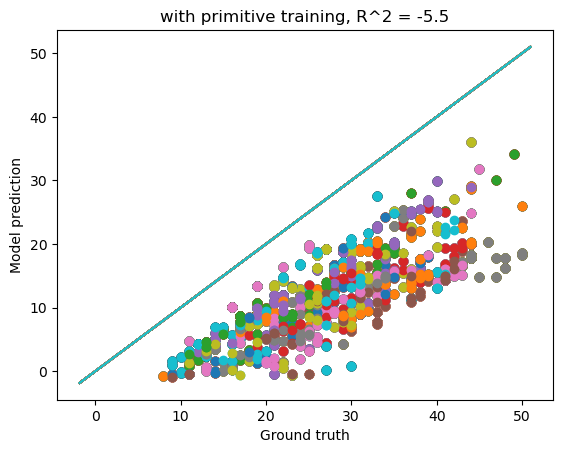

In [31]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_Xother(ops, all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res6  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res6])
acc_train = np.array([r['acc'][:,0] for r in res6]).T
acc_test = np.array([r['acc'][:,1] for r in res6]).T
mods = [r['mod'] for r in res6]
tests = [r['test'] for r in res6]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [18]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 5)

In [427]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        
        self.initialize_weights()

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)


time:  8.89250924984614


,label,pred,acc
trial,,,
"['C', '+', 'A', '+', 'D']",28.9375,27.442628,0.1250
"['C', '+', 'F', '+', 'A']",27.1875,25.527601,0.0625
"['D', '+', 'D', '+', 'A']",31.3750,29.783678,0.0625
"['E', '+', 'B', '+', 'A']",26.1875,25.329617,0.0625
"['C', '+', 'C', '+', 'A']",26.5000,24.721870,0.0000


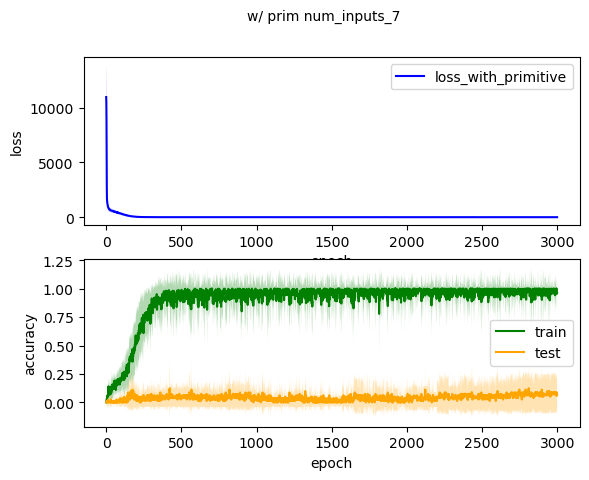

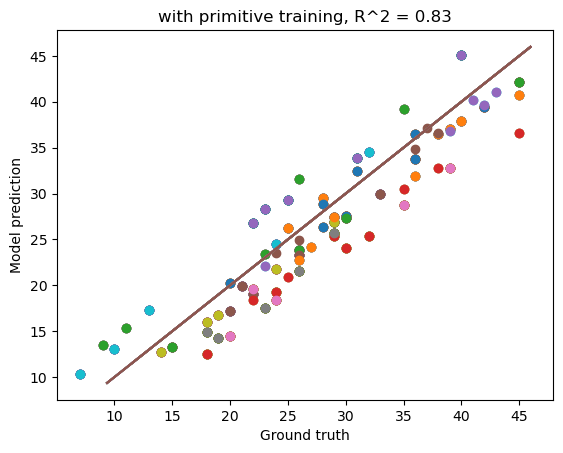

In [428]:
epochs = 3000
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 5)

t1 = time.time()
res4  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res4])
acc_train = np.array([r['acc'][:,0] for r in res4]).T
acc_test = np.array([r['acc'][:,1] for r in res4]).T
mods = [r['mod'] for r in res4]
tests = [r['test'] for r in res4]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [54]:
os.system("printf '\a'") # or '\7'




0